# System Identification in Frequency Domain

In [8]:
import os
import sys
import pywt
import itertools
from itertools import zip_longest
import numpy as np
from numpy.linalg import norm
import math
import pandas as pd
from scipy.fftpack import fft
from scipy.signal import welch, periodogram
from scipy.stats import ranksums
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from statsmodels.tsa.api import VAR
from tqdm import tqdm_notebook
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.ticker import FormatStrFormatter

from scipy.io import loadmat
import seaborn as sns
from math import floor
import tkinter as tk
import decimal
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import concurrent.futures # for parallel processing
import glob
import pickle

# Loading The Dataset (Trial by Trial)

In [2]:
# Get the participant data from Dataset directory
global t0, fs, dt, num_eeg_ch, num_emg_ch, num_force_ch, num_ch, num_conds
t0 = 0
fs = 1200
dt = 1.0/fs
num_eeg_ch = 14
num_emg_ch = 4
num_force_ch = 3
num_ch = num_eeg_ch + num_emg_ch + num_force_ch
num_conds = 18

# Get a list of files to process
data_files = list(map(loadmat, glob.glob("Dataset/*.mat")))
num_participants = len(data_files)

columns=['EEG-1','EEG-2','EEG-3','EEG-4','EEG-5',
         'EEG-6','EEG-7','EEG-8','EEG-9','EEG-10',
         'EEG-11','EEG-12','EEG-13','EEG-14','EMG-1',
         'EMG-2','EMG-3','EMG-4','Force-x', 
         'Force-y','Force-z']

glob.glob("Dataset/*.mat")

['Dataset/JT1200Hz.mat',
 'Dataset/KH1200Hz.mat',
 'Dataset/YA1200Hz.mat',
 'Dataset/P11200Hz.mat',
 'Dataset/WC1200Hz.mat',
 'Dataset/BT1200Hz.mat',
 'Dataset/ED1200Hz.mat',
 'Dataset/CC1200Hz.mat',
 'Dataset/HCH1200Hz.mat',
 'Dataset/YZ1200Hz.mat',
 'Dataset/YK1200Hz.mat']

In [3]:
def extract_data(file):
    data_splitBy_trials = [] # list of data frames, each df corresponding to a trial

    for cond in tqdm_notebook(range(num_conds), ascii=True):
        num_trials = file['EEGSeg_Ch'][0,0][0,cond].shape[0]
        # if a trial has long enough samples
        if file['EEGSeg_Ch'][0,0][0,cond].shape[1] >= 400:
            for trial in range(num_trials): 
                data = pd.DataFrame(columns=columns)
                for ch in range(num_eeg_ch):
                    data.iloc[:,ch] = file['EEGSeg_Ch'][0,ch][0,cond][trial,:]
                for ch in range(num_emg_ch):
                    data.iloc[:,ch+num_eeg_ch] = file['EMGSeg_Ch'][0,ch][0,cond][trial,:]
                for ch in range(num_force_ch):
                    data.iloc[:,ch+num_eeg_ch+num_emg_ch] = file['ForceSeg_Ch'][0,ch][0,cond][trial,:]

                # mean subtraction in each trial from the eeg and emg columns for removing dc drift
                data.iloc[:,:18] -= data.iloc[:,:18].mean()
                # convert volts to microvolts for EEG and EMG channels
                data.iloc[:,:18] *= 1e6
                # convert volts to milivolts for force channels
                data.iloc[:,18:] *= 1e3  
                data_splitBy_trials.append(data)
                
    train_data, test_data = train_test_split(data_splitBy_trials)
    return train_data, test_data


def train_test_split(data, train_ratio=0.9):
    '''
    with train ratio=x, we use x ratio of the trials from a participant for training 
    and other trials for testing
    '''
    num_train = int(train_ratio*len(data))
    train_data, test_data = data[:num_train], data[num_train:]
    return train_data, test_data


train_data = [] # train data is a list (all participants each trial) of dataframes
test_data = [] # test data is a list (each participant) of list (each trial) of dataframes 

print('Reading and processing in parallel.')

# Create a pool of processes. By default, one is created for each CPU in your machine.
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Process the list of files, but split the work across the process pool to use all CPUs.
    # executor.map() function takes in the helper function to call and the list of data to process with it.
    # executor.map() function returns results in  the same order as the list of data given to the process.
    for train, test in tqdm_notebook(executor.map(extract_data, data_files), total=len(data_files)):
        train_data.extend(train)
        test_data.append(test)
        
total_trials = len(train_data)
for test in test_data:
    total_trials += len(test)
print('Total number of trials of all the conditions in the file: %i' %total_trials) 
train_data[0].head(10) # first 10 samples of the first trial

Reading and processing in parallel.











Total number of trials of all the conditions in the file: 17648


,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5,EEG-6,EEG-7,EEG-8,EEG-9,EEG-10,...,EEG-12,EEG-13,EEG-14,EMG-1,EMG-2,EMG-3,EMG-4,Force-x,Force-y,Force-z
0,-4.061266,-2.748395,-4.159137,-3.303524,-4.237834,-3.263690,-4.293166,-5.489011,-6.247454,-5.444957,...,-5.186769,-7.655287,-8.287395,304.313191,120.098380,-157.394203,-1753.390839,-192.723259,-192.301840,58.057401
1,-4.323288,-2.915330,-4.371163,-3.388422,-4.178222,-3.273949,-4.240327,-5.727081,-6.321096,-5.249596,...,-5.191572,-7.865369,-8.608392,390.857272,134.463099,-183.568442,-1734.436562,-192.711279,-192.295104,58.058884
2,-4.331330,-2.866236,-4.347684,-3.306386,-3.899337,-3.103404,-4.001369,-5.782397,-6.173475,-4.850811,...,-5.003071,-7.824185,-8.615898,-38.283132,85.244564,-165.401598,-1678.423097,-192.665175,-192.245647,58.112554
3,-4.067382,-2.578846,-4.076276,-3.048814,-3.405168,-2.744989,-3.571455,-5.644256,-5.805605,-4.252133,...,-4.619291,-7.530333,-8.302589,-301.828794,71.207670,-107.396034,-1576.171329,-192.289367,-191.877589,58.514018
4,-3.529945,-2.039669,-3.557012,-2.610991,-2.711042,-2.200528,-2.954523,-5.310555,-5.228050,-3.464128,...,-4.048190,-6.993623,-7.675014,277.433359,75.663117,-57.585935,-1594.395449,-191.367984,-190.961048,59.535619
5,-2.735292,-1.247311,-2.804010,-1.994420,-1.844097,-1.482724,-2.165177,-4.789175,-4.461573,-2.506033,...,-3.309188,-6.235868,-6.754635,397.400745,51.240114,-110.385464,-1637.772729,-189.688250,-189.266205,61.450873
6,-1.717561,-0.215165,-1.846069,-1.209068,-0.843088,-0.616612,-1.230061,-4.098956,-3.537264,-1.406988,...,-2.433880,-5.291038,-5.578263,288.710744,-88.115546,-80.302406,-1704.842856,-187.486127,-187.046602,63.953906
7,-0.527355,1.027101,-0.726199,-0.275009,0.242814,0.360111,-0.188119,-3.269845,-2.496003,-0.206604,...,-1.465739,-4.204645,-4.197301,261.075609,-244.309517,21.671887,-1727.909853,-185.352355,-184.940532,66.287600
8,0.771227,2.433590,0.500280,0.776952,1.356180,1.398053,0.910233,-2.342160,-1.387033,1.045633,...,-0.458593,-3.032174,-2.675825,72.066486,-305.091354,99.133827,-1704.440524,-183.718845,-183.315605,68.093076
9,2.104610,3.943617,1.768688,1.905645,2.434227,2.438277,2.005101,-1.365000,-0.265795,2.292088,...,0.526093,-1.836652,-1.087690,48.050471,-232.463094,123.487039,-1553.625872,-182.716638,-182.316095,69.207713


In [4]:
trial_id = 40 # choose one trial
num_samples = train_data[trial_id].shape[0]
time = (np.arange(0, num_samples) * dt + t0) * 1e3
# pick one channel from eeg, emg and force
eeg_signal_1 = train_data[trial_id].iloc[:,0] # trial id, eeg_ch1
emg_signal_1 = train_data[trial_id].iloc[:,14] # trial id, emg_ch1
force_signal_3 = train_data[trial_id].iloc[:,20] # trial id, force_ch3

# Visualization of The Dataset

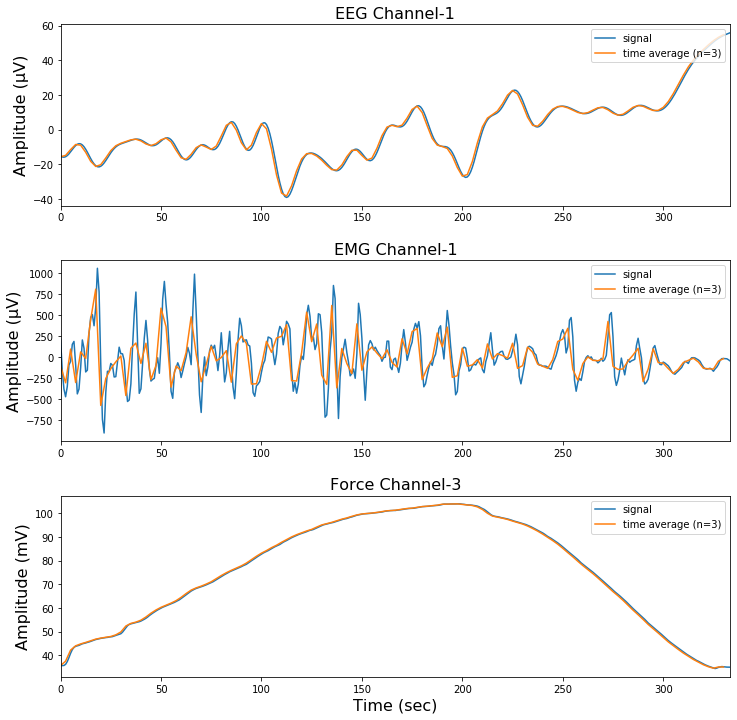

In [5]:
def get_ave_values(xvalues, yvalues, n):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

def plot_signal_plus_average(ax, time, signal, average_over):
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(average_over))
    ax.set_xlim([time[0], time[-1]])
    ax.legend(loc='upper right')

fig, axes = plt.subplots(3, figsize=(12,12))
fig.subplots_adjust(hspace=0.3)
plot_signal_plus_average(axes[0], time, eeg_signal_1, average_over=3)

axes[0].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[0].set_title('EEG Channel-1', fontsize=16)
plot_signal_plus_average(axes[1], time, emg_signal_1, average_over=3)

axes[1].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[1].set_title('EMG Channel-1', fontsize=16)
plot_signal_plus_average(axes[2], time, force_signal_3, average_over=3)

axes[2].set_ylabel('Amplitude (mV)', fontsize=16)
axes[2].set_xlabel('Time (sec)', fontsize=16)
axes[2].set_title('Force Channel-3', fontsize=16)

plt.show()

# Fourier Transform of The Data

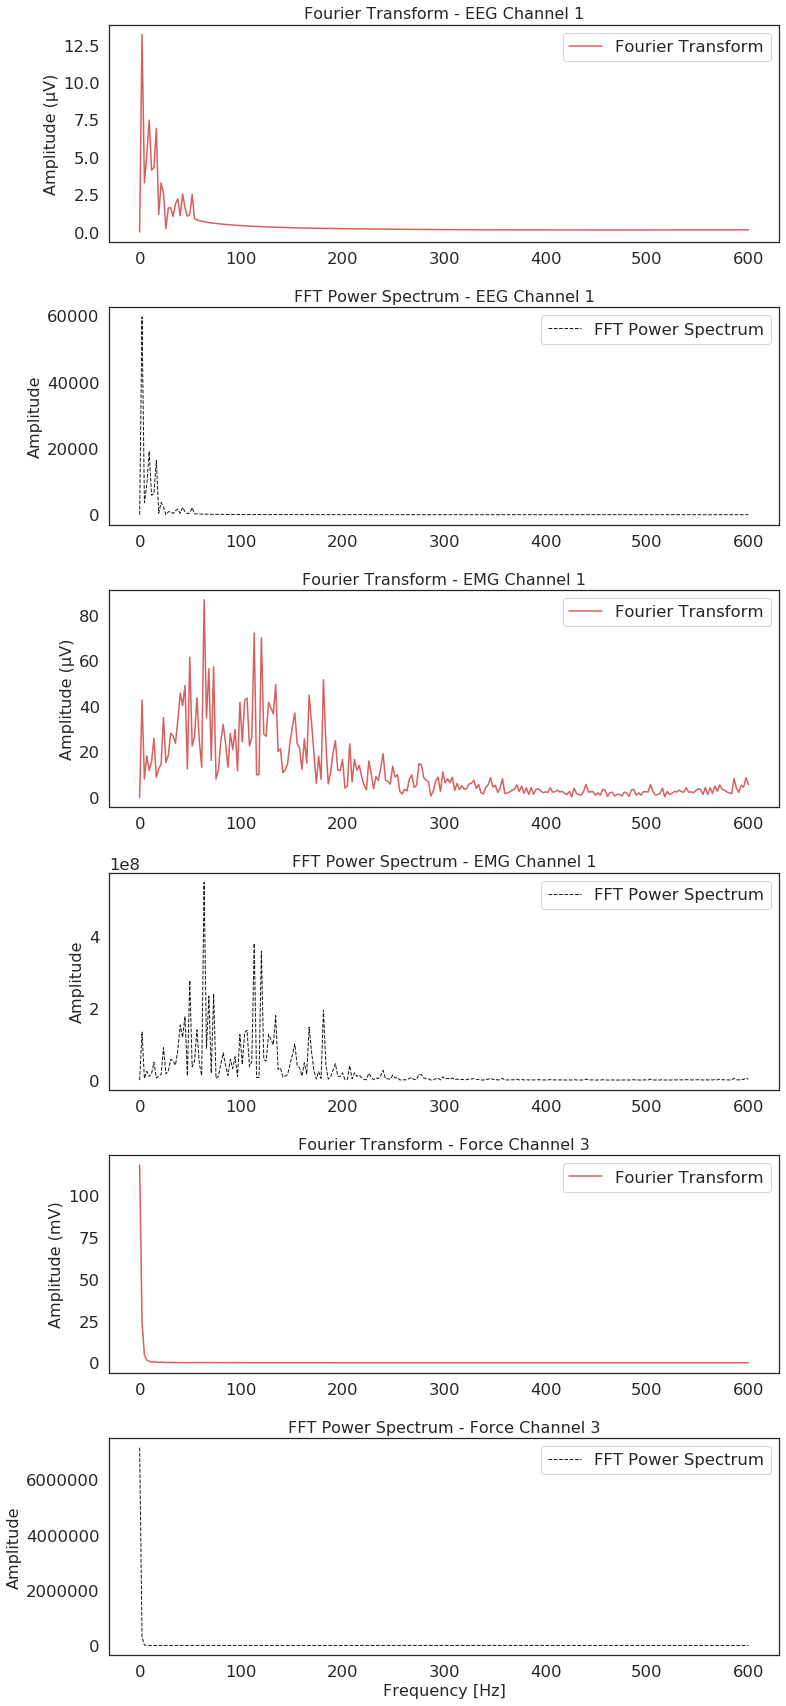

In [93]:
def get_fft_values(y_values, dt, N):
    N2 = 2 ** (int(np.log2(N)) + 1) # round up to next highest power of 2
    f_values = np.linspace(0.0, 1.0/(2.0*dt), N2//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N2 * np.abs(fft_values_[0:N2//2])
    return f_values, fft_values

def plot_fft_plus_power(axes, time, signal, N, fs=fs, dt=dt,
                        plot_direction='horizontal', yticks=None, ylim=None):
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N)
    fft_power = variance * abs(fft_values) ** 2

    if plot_direction == 'horizontal':
        axes[0].plot(f_values, fft_values, 'r-', label='Fourier Transform')
        axes[1].plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    elif plot_direction == 'vertical':
        scales = 1./f_values
        scales_log = np.log2(scales)
        axes[0].plot(fft_values, scales_log, 'r-', label='Fourier Transform')
        axes[1].plot(fft_power, scales_log, 'k--', linewidth=1, label='FFT Power Spectrum')
        axes[0].set_yticks(np.log2(yticks))
        axes[0].set_yticklabels(yticks)
        axes[0].invert_yaxis()
        axes[0].set_ylim(ylim[0], -1)
    axes[0].legend()
    axes[1].legend()

fig, axes = plt.subplots(6, figsize=(12,30))
fig.subplots_adjust(hspace=0.3)
axes[0].set_title('Fourier Transform - EEG Channel 1', fontsize=16)
axes[1].set_title('FFT Power Spectrum - EEG Channel 1', fontsize=16)
axes[0].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[1].set_ylabel('Amplitude', fontsize=16)
plot_fft_plus_power([axes[0], axes[1]], time, eeg_signal_1, len(eeg_signal_1))

axes[2].set_title('Fourier Transform - EMG Channel 1', fontsize=16)
axes[3].set_title('FFT Power Spectrum - EMG Channel 1', fontsize=16)
axes[2].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[3].set_ylabel('Amplitude', fontsize=16)
plot_fft_plus_power([axes[2], axes[3]], time, emg_signal_1, len(emg_signal_1))

axes[4].set_title('Fourier Transform - Force Channel 3', fontsize=16)
axes[5].set_title('FFT Power Spectrum - Force Channel 3', fontsize=16)
axes[4].set_ylabel('Amplitude (mV)', fontsize=16)
axes[5].set_ylabel('Amplitude', fontsize=16)
plot_fft_plus_power([axes[4], axes[5]], time, force_signal_3, len(force_signal_3))
axes[5].set_xlabel('Frequency [Hz]', fontsize=16)

plt.show()

# Estimation of The Power Spectral Density Using Welch’s Method

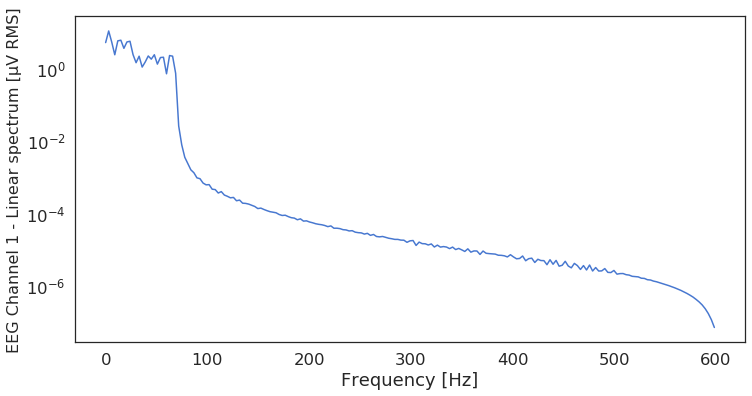

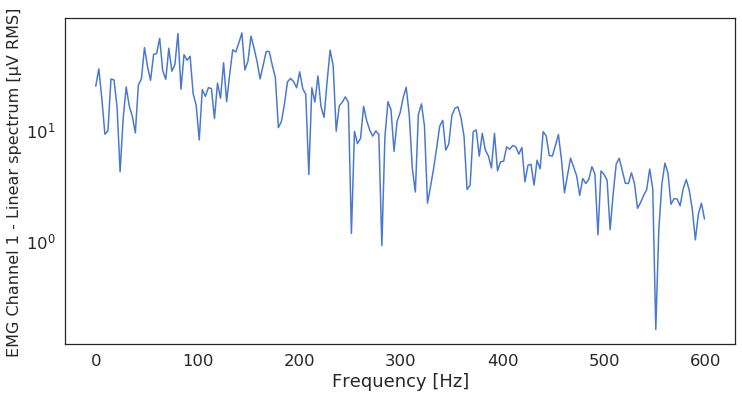

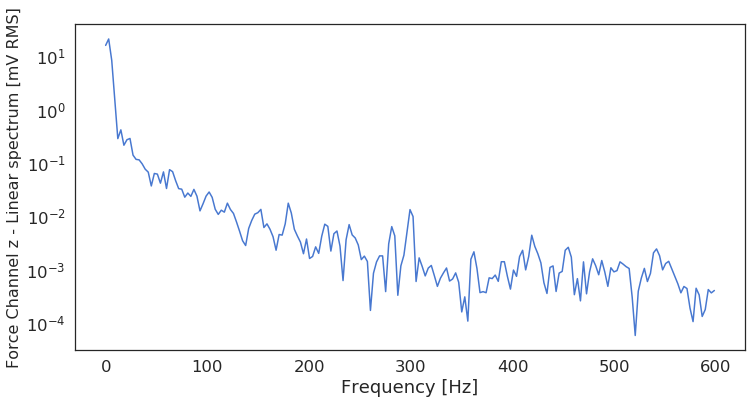

In [94]:
# Welch’s method computes an estimate of the power spectral density by dividing the data
# into overlapping segments, computing a modified periodogram for each segment 
# and averaging the periodograms.

# For the default ‘hanning’ window an overlap of 50% is a reasonable trade off 
# between accurately estimating the signal power, while not over counting any of the data. 
# Narrower windows may require a larger overlap.
for counter, x in enumerate([eeg_signal_1, emg_signal_1, force_signal_3]):
    f, Pxx_spec = welch(x, fs, 'hanning', len(x), scaling='spectrum')
    plt.figure(figsize=(12,6))    
    plt.semilogy(f, np.sqrt(Pxx_spec))
    plt.xlabel('Frequency [Hz]')
    if counter == 0:
        plt.ylabel('EEG Channel 1 - Linear spectrum [\u03bcV RMS]', fontsize=16)
    elif counter == 1:
        plt.ylabel('EMG Channel 1 - Linear spectrum [\u03bcV RMS]', fontsize=16)
    else:
        plt.ylabel('Force Channel z - Linear spectrum [mV RMS]', fontsize=16)
    plt.show()
    
# The peak height in the power spectrum is an estimate of the RMS amplitude.

# Wavelet Decomposition Level Selection

In [154]:
def spectral_entropy(signal, fs=1200, method='fft', nperseg=None, normalize=True):
    """
    Evaluates the complexity of a one dimensional time series

    Parameters
    ----------
    signal: list or np.array
        One-dimensional time series of shape (n_times)
    fs: float
        Sampling frequency, in Hz.
    method: str
        Spectral estimation method:
        * "fft": Fourier Transform (:py:func:`scipy.signal.periodogram`)
        * "welch": Welch periodogram (:py:func:`scipy.signal.welch`)
    nperseg : int or None
        Length of each FFT segment for Welch method.
        If None (default), uses scipy default of 256 samples.
    normalize : bool
        If True, divide by log2(psd.size) to normalize the spectral entropy
        between 0 and 1. Otherwise, return the spectral entropy in bit.
    
    Returns
    ----------
    spectral_entropy : float
        Spectral Entropy
    
    Description
    ----------
    Spectral Entropy is defined to be the Shannon entropy of the power
    spectral density (PSD) of the data:
    .. math:: H(x, sf) =  -\\sum_{f=0}^{f_s/2} P(f) log_2[P(f)]
    Where :math:`P` is the normalised PSD, and :math:`f_s` is the sampling frequency.
    """
    signal = np.array(signal)
    # Compute and normalize power spectrum
    if method == 'fft':
        _, psd = periodogram(signal, fs)
    elif method == 'welch':
        _, psd = welch(signal, fs, nperseg=nperseg)
    psd_norm = np.divide(psd, psd.sum())
    spectral_entropy = -np.multiply(psd_norm, np.log2(psd_norm)).sum()
    if normalize:
        spectral_entropy /= np.log2(psd_norm.size)
    return spectral_entropy


def select_resolution(signal, max_level):
    '''
    Select the level of wavelet decomposition
    
    Parameters
    ----------
    signal: list or np.array
        One dimensional time series
    fs: float
        sampling frequency of the signal in Hz
    max_level: int
        maximum number of wavelet decompositions
               
    Returns
    ----------
    se: list, length: max_level
        a list of spectral entropy values to describe the complexity of the system  
    '''
    se = []
    for i in range(max_level):
        cA, cD = pywt.dwt(signal, 'db4')
        se.append(spectral_entropy(cD, fs=1200, method='welch', normalize=True))
        signal = pywt.idwt(cA, np.zeros(len(cA)), 'db4')
    return se 

In [155]:
def _test_select_resolution(signal):
    '''
    Plots the spectral entropy of a given one dimensional signal and saves the 
    figure in the VARResults directory.
    
    Parameters
    ----------
    signal: list or np.array
        One dimensional time series 
    '''
    _max = 10
    se = select_resolution(signal, max_level=_max)
    print(se)
    data = {'decomposition levels':list(range(1,_max+1,1)), 'entropy':se} 
    df = pd.DataFrame(data) 
    sns.set(style="white", palette="muted", color_codes=True, font_scale=1.5)
    sns.despine()
    ax = sns.lineplot(x="decomposition levels", y="entropy", data=df)
    for i in range(1,_max,1):
        ax.vlines(x=i, ymin=df['entropy'].min(), 
                       ymax=df['entropy'].max(), color='black', 
                  alpha=1, linewidth=1, linestyles='dotted')
    plt.tight_layout()
    plt.savefig("VARResults/entropy_per_decomposition.pdf", bbox_inches="tight")
    plt.show()

[0.3104773508538492, 0.13097919856695325, 0.13097940488120166, 0.13097940498127428, 0.1309794049814194, 0.13097940498139596, 0.13097940498135666, 0.13097940498134833, 0.13097940498135083, 0.1309794049813697]


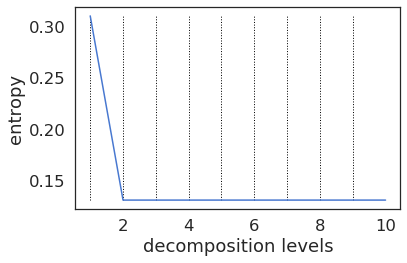

In [158]:
signal = test_data[1][2]['EEG-5']
_test_select_resolution(signal)